In [2]:
pip install git+https://github.com/LucianoPereiraValenzuela/ECC_2025_testing.git 

  Cloning https://github.com/LucianoPereiraValenzuela/ECC_2025_testing.git to c:\users\lucia\appdata\local\temp\pip-req-build-zt2tm51t
  Resolved https://github.com/LucianoPereiraValenzuela/ECC_2025_testing.git to commit c8db57376f9955954750b32781958c406ddd98af
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/LucianoPereiraValenzuela/ECC_2025_testing.git 'C:\Users\lucia\AppData\Local\Temp\pip-req-build-zt2tm51t'


In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
from qiskit import QuantumCircuit
from qiskit_aer.primitives import Sampler 
from qiskit.circuit import ParameterVector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.circuit.library import RawFeatureVector
from keras.layers import Dense
from keras import Input, Model

Los __autoencoder__ son un tipo arquitectura de red neuronal para eficientemente comprimir y codificar datos. Estos están tipicamente divididos en tres capas, como podemos ver en la siguiente figura.

La primera capa, llamda __capa de entrada__, es donde introducimos nuestros datos. Luego la data pasa a través de un encoder y viaja a la siguiente capa, la cual tiene menos nodos que la capa de entrada. Esto produce una reducción en la dimensión de los datos, por lo que es llamada __capa bottleneck__ (cuello de botella). Un autoencoder puede tener varias de estas capas. Finalmente los datos comprimidos pasan a la __capa de salida__. Acá los datos son restaurados a su tamaño original por un proceso de decodificación. 

De este modo, los autoencoder permiten reducción de dimensión de los datos de entrada mientras manteniendo lo más posible de su información. Debido a esto, los autoencoder son tipicamente utilisados para reducción de ruido, detección de anomalias, reconocimiento facial y modelos generativos []. 

En analogía a los autoencoders clásicos, los autoencoder cuánticos pueden usarse para comprimir información cuántica. Acá cada qubit representa un nodo de la red neuronal, mientras que transformaciones unitarias representan las conexiones entre los nodos, tal como se ve en la figura. 

Consideremos que tenemos datos de entados representados por un estado cuántico $|\psi\rangle$ de $n+k$ qubits. Mediante una evolución unitaria $U$ y mediciones en los primeros $k$ qubits, transformamos este estado en un estado producto $|0\cdots0\rangle|\psi'\rangle$, donde $|0\cdots0\rangle$ es un estado de $k$ qubits y $|\psi'\rangle$ es un nuevo estado cuántico de $n$ qubits. De este modo logramos comprimir la información, pues pasamos de un estado de $n+k$ qubits a un estado de solo $n$ qubits. Luego, mediente otra transformación unitaria $V$ recuperamos el tamaño original de los datos. 

El entrenamiento del autoencoder cuántico consiste en encontrar las unitarias $U(\theta)$ de codificación y $V(\theta)$ de decodificación, ambas representadas por circuitos cuánticos paramétricos. Esto se puede realizar maximizando la probabilidad de obtener el resultado $|0\cdots0\rangle$ en las medidas intermedias, es decir,
\begin{equation}
 F(\theta) = \langle \psi | U(\theta)^\dagger\left( |0\cdots 0\rangle\langle 0\cdots0|\otimes I \right) U(\theta)|\psi\rangle .
\end{equation}
El decodificador viene dado por el adjunto del codificador, es decir $V(\theta)=U(\theta)^\dagger$. 

__Problema:__ Consideremos que queremos comprimir una imagen. La escala de gris de cada pixel de esta imagen esta guardada en el array ``image``. Construya un circuito cuántico de 4 qubits que codifique esta figura en la aplitud del estado cuántico. Esto se puede realizar utilizando la función ``RawFeatureVector`` de ``qiskit``.

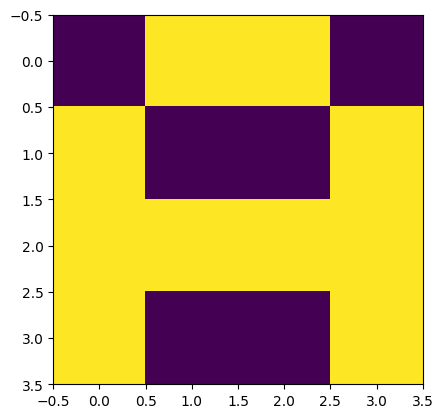

In [4]:
image = np.zeros( ( 2**2, 2**2 ) )
image[[1,2,3],[0,0,0]] = 1
image[[0,2,0,2],[1,1,2,2]] = 1
image[[1,2,3],[3,3,3]] = 1

plt.imshow( image ) 

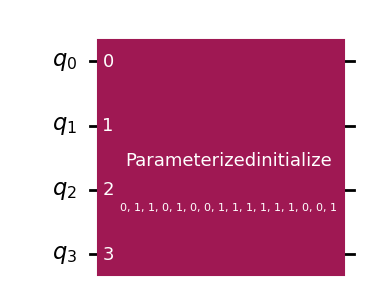

In [5]:
num_qubits = 4

qc_data = RawFeatureVector( 2**num_qubits )
qc_data = qc_data.assign_parameters( image.flatten() )

qc_data.draw('mpl') 

__Problema:__ Construya el circuit cuántico paramétrico $U(\theta)$ de la siguiente figura para representar al codificador. 

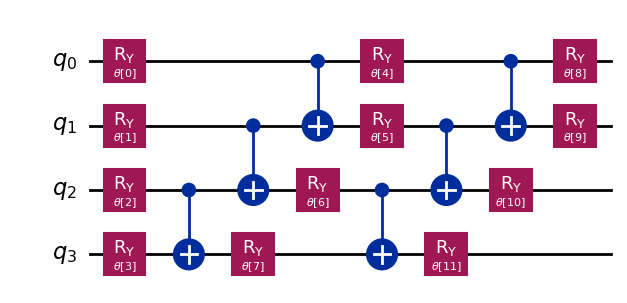

In [6]:
num_layers = 2
num_params = num_qubits*(num_layers+1)
theta = ParameterVector(r'$\theta$', num_params )

qc_encoder = QuantumCircuit(num_qubits)
j=0

for l in range(num_layers):
    for k in range(num_qubits):
        qc_encoder.ry(theta[j],k)
        j=j+1
    for k in range(num_qubits-1):
        qc_encoder.cx( num_qubits-k-2, num_qubits-k-1 )
for k in range(num_qubits):
    qc_encoder.ry(theta[j],k)
    j=j+1

qc_encoder.draw('mpl')

__Problema:__ Construya una función que evalue la función objetivo $F(\theta)$. Esto requiere construir el circuito representado en la siguiente figura, ejecutarlo, y extraer el resultado asociado a $0\cdots0$.

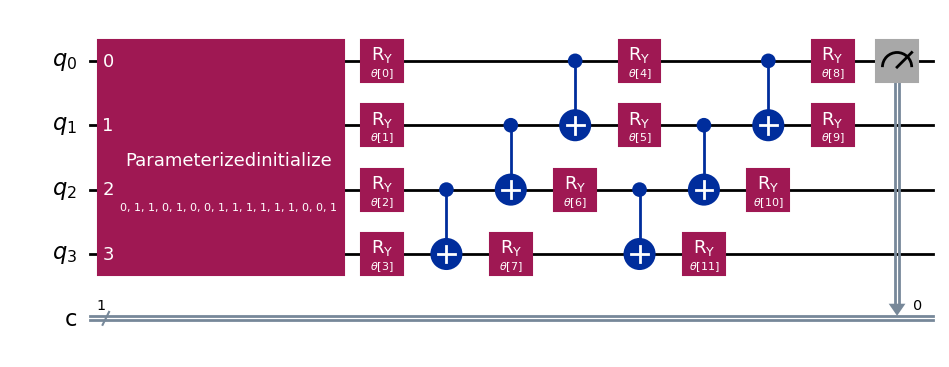

In [7]:
backend = Sampler()
num_qubits_trash = 1

qc = QuantumCircuit( num_qubits, num_qubits_trash )
qc.compose( qc_data, inplace=True )
qc.compose( qc_encoder, inplace=True )
qc.measure(range(num_qubits_trash), range(num_qubits_trash))

def fun( params ):
    job   = backend.run( qc, params )
    probs = job.result().quasi_dists[0].get( 0, 0 ) 
    qc.draw('mpl')
    return 1-probs 

qc.draw('mpl', fold=-1)


In [8]:
xs = []
def callback(x):
    xs.append(fun(x))

optimizer = COBYLA( callback=callback, maxiter=100 ) 
results   = optimizer.minimize( fun, np.zeros(num_params) )
params_opt = results.x 
1-results.fun 

np.float64(0.95703125)

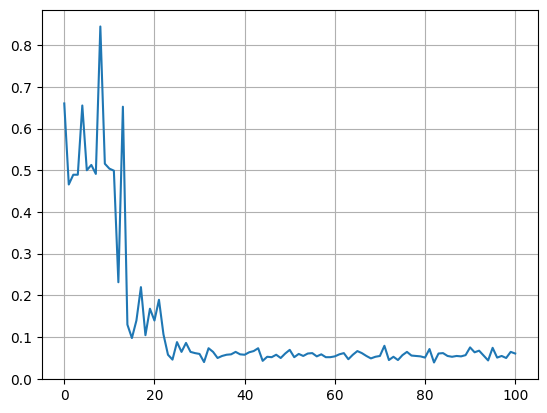

In [9]:
plt.plot( xs ) 
plt.grid()

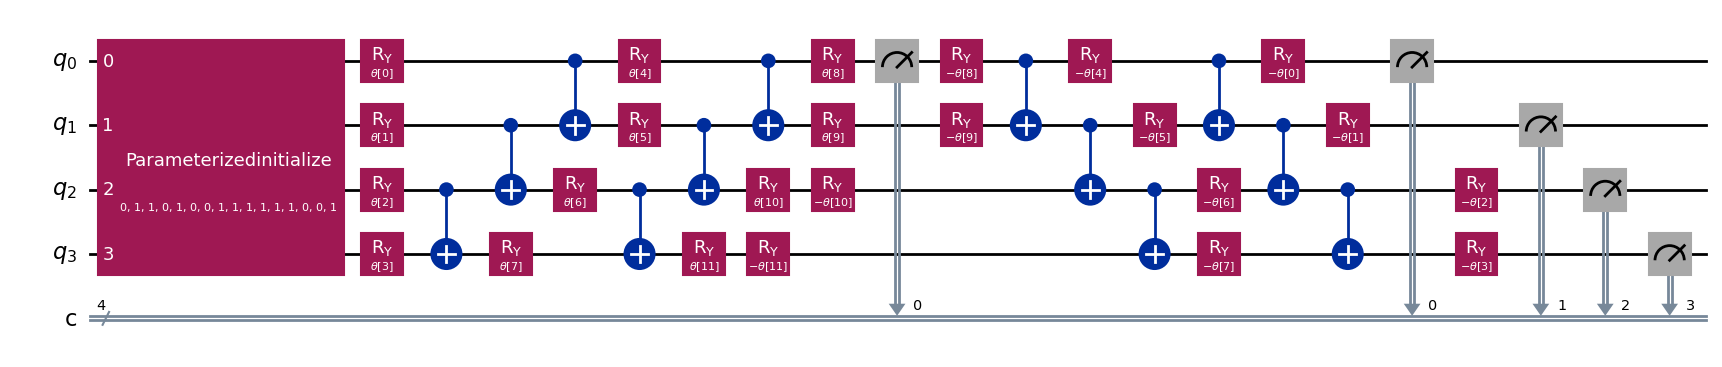

In [10]:
qc_decoder = QuantumCircuit( num_qubits, num_qubits )
qc_decoder.compose( qc, qubits=range(num_qubits), clbits=range(num_qubits_trash), inplace=True)
qc_decoder.compose( qc_encoder.inverse(), inplace=True )
qc_decoder.measure( range(num_qubits), range(num_qubits) )
qc_decoder.draw('mpl', fold=-1 ) 

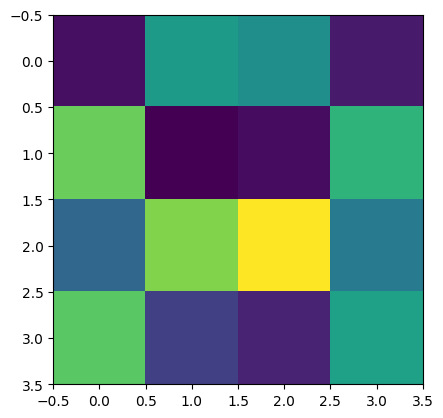

In [11]:
job   = backend.run( qc_decoder, params_opt )
probs = job.result().quasi_dists[0]

image_out = np.zeros(2**num_qubits)
for j in probs:
    image_out[j] = probs[j]
image_out = image_out.reshape(4,4)

plt.imshow( image_out )

Entrenemos un autoencoder clásico para compararlo con su versión cuántica.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


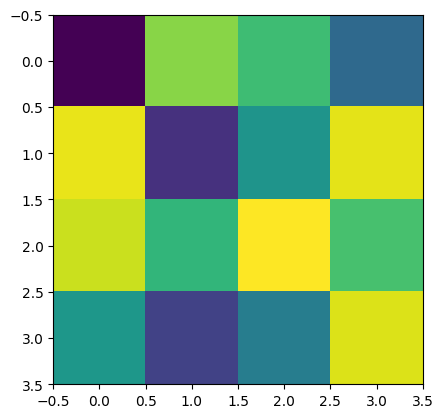

In [12]:
# Creamos modelo para el autoencoder
input_dim = 16
encoding_dim = 8
input_img = Input(shape=(input_dim,))
# Encoding
encoded = Dense(encoding_dim, activation='sigmoid')(input_img)
# Decoding
decoded = Dense(input_dim, activation='sigmoid')(encoded)
# Modelo
autoencoder = Model(input_img, decoded)

# Este modelo es para ver la imagen decodificada
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

# Definimos optimizador y función objetivo
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Entrenamiento 
x = image.reshape(1,-1) 
autoencoder.fit( x, x, epochs=100, verbose=0 )

# Graficando imagen decodificada 
encoded_img = encoder.predict(x)
decoded_img = decoder.predict(encoded_img)
plt.imshow( decoded_img.reshape(4,4) ) 

Por simplicidad, en este taller hemos estudiado la codificación de una única imagen. Si queremos comprimir un conjunto de imagenes con un autoencoder cuántico debemos recurrir al formalismo de las matrices densidad. En este caso cada imagen tendrá asociada un estado cuántico $|\psi_i\rangle$ con una probabilidad $p_i$, lo cual es conocido como un ensamble de estados puros. De este modo, la función objetivo vendrá dada por 
\begin{equation*}
 F(\theta) =  {\rm Tr}\left[U(\theta) \rho U(\theta)^\dagger\left( |0\cdots 0\rangle\langle 0\cdots0|\otimes I \right) \right],
\end{equation*}
donde $\rho$ es la matriz densidad asociada con el ensamble de estados puros $\{ p_i, |\psi_i\rangle \}$,
\begin{equation*}
    \rho = \sum_i p_i |\psi_i\rangle\langle \psi_i |.
\end{equation*}
La preparación de matrices densidad se puede realizar de varias formas, entre las que tenemos el uso de qubit auxiliares, medidas intermedias, o muestreo. 